# Session4 Project mission.  미국 항공사 sns 반응 분석하기.

# 프로젝트 소개(Project introduce)<br>
- 이 데이터는 2015.2월부터 미국의 각 항공사 에서 트위터에 작성된 사용자의 경험을 csv, sql 데이터로 가공한 자료 입니다.<br> 
- 감정분석에 필요한 모든 과정(라벨링)이 다 되어 있으므로 이 문서에서는 감정 분류를 하고 그에 따른 결과 분석을 통해 유저들이 항공사에 대해 어떤 생각을 갖고 있는지 알아보는 것이 이 프로젝트의 목적입니다.<br>
- 자료 출처 : https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment

## 1. 'pip' 명령어를 통한 시스템 패키지 인스톨('pip' system pakege install)

In [5]:
!pip install gensim --upgrade
!pip install keras --upgrade
!pip install --upgrade tensorflow
!pip install pandas --upgrade
!pip install kaggle

     |████████████████████████████████| 24.1 MB 1.2 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
     |████████████████████████████████| 462 kB 7.4 MB/s 


## 2. Total pakege set

In [6]:
#dataframe
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import seaborn as sns

#matplot
import matplotlib.pyplot as plt

#Scikit-learn set
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

#Keres set
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

#Word2vec
import gensim

#Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools
import warnings
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
import pickle, joblib
import sqlite3 #데이터 

## 3. 자료 불러오기(Data load) - 캐글 데이터 연결(kaggle data connected)

In [7]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jieunjeongrouis","key":"5f6b3ca997a1621217a0c71f7e9e9fcb"}'}

In [8]:
#kaggle json file check
!ls -1ha kaggle.json

kaggle.json


In [9]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

#Permission warning 방지
!chmod 600 ~/.kaggle/kaggle.json

In [10]:
#사용할 데이터셋 api 위치
!kaggle datasets download -d crowdflower/twitter-airline-sentiment

  0% 0.00/2.55M [00:00<?, ?B/s]
100% 2.55M/2.55M [00:00<00:00, 172MB/s]


In [11]:
#data set total check
!ls

kaggle.json  sample_data  twitter-airline-sentiment.zip


In [12]:
# 압축해제 
!unzip twitter-airline-sentiment.zip

Archive:  twitter-airline-sentiment.zip
  inflating: Tweets.csv              
  inflating: database.sqlite         


In [13]:
#data set, set up
connection = sqlite3.connect('/content/database.sqlite')
quert = "select * from sqlite_master"
db = pd.read_sql_query(sql = quert, con = connection)
db

,type,name,tbl_name,rootpage,sql
0,table,Tweets,Tweets,2,CREATE TABLE Tweets (\n tweet_id INTEGER PR...


In [14]:
#쿼리로 분석에 필요한 것을 테이블에서 검색해서 읽어오기
query = "SELECT airline, text, negativereason, airline_sentiment AS sentiment FROM 'Tweets'"

df = pd.read_sql_query(sql = query, con = connection)

display(df.shape, df.head(), df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14485 entries, 0 to 14484
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   airline         14485 non-null  object
 1   text            14485 non-null  object
 2   negativereason  14485 non-null  object
 3   sentiment       14485 non-null  object
dtypes: object(4)
memory usage: 452.8+ KB


(14485, 4)

,airline,text,negativereason,sentiment
0,Delta,@JetBlue's new CEO seeks the right balance to ...,,neutral
1,Delta,@JetBlue is REALLY getting on my nerves !! 😡😡 ...,Can't Tell,negative
2,United,@united yes. We waited in line for almost an h...,Late Flight,negative
3,United,@united the we got into the gate at IAH on tim...,Late Flight,negative
4,Southwest,@SouthwestAir its cool that my bags take a bit...,Customer Service Issue,negative


None

### 2. EDA

#### - 항공사별 총합 (Total count per Airlines)

In [1]:
#한글깨짐
!apt-get update -qq
!apt-get install fonts-nanum* -qq

import matplotlib.font_manager as fm
import warnings
warnings.filterwarnings(action='ignore') 

path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf' # 나눔 고딕
font_name = fm.FontProperties(fname=path, size=10).get_name() # 기본 폰트 사이즈 : 10
plt.rc('font', family=font_name)
fm._rebuild()

Selecting previously unselected package fonts-nanum.
(Reading database ... 155335 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20170925-1_all.deb ...
Unpacking fonts-nanum (20170925-1) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-6_all.deb ...
Unpacking fonts-nanum-eco (1.000-6) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20170925-1_all.deb ...
Unpacking fonts-nanum-extra (20170925-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-1_all.deb ...
Unpacking fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-extra (20170925-1) ...
Setting up fonts-nanum (20170925-1) ...
Setting up fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-eco (1.000-6) ...
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...


NameError: ignored

In [18]:
#항공사 트윗 반응 구하기 'groupby' 함수를 통해 항공사 별로 데이터 수집
a = df.groupby(['airline', 'sentiment'])['sentiment'].count().unstack()
# a['total'] =  [a.values[x].sum() for x in range(0,6)]
a

sentiment,negative,neutral,positive
airline,,,
American,1864,433,307
Delta,955,723,544
Southwest,1186,664,570
US Airways,2263,381,269
United,2633,697,492
Virgin America,181,171,152


In [1]:
ax = sns.countplot(data = df, y = 'airline',
                   order = df.airline.value_counts().index)
#ax.bar_label(ax.containers[0])
ax.set_title('트위터 기준 항공사별 단어 사용 횟수(Count per Airlines)',)
                                    
plt.show()

NameError: ignored

#### - 감정 비율(Proportion of Sentiments)

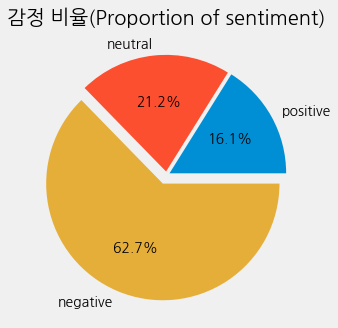

In [ ]:
x = df.sentiment.value_counts().sort_values()

plt.figure(figsize=(5, 5))
ax = plt.pie(x = x, labels=x.index, autopct = '%1.1f%%', explode = [0.03, 0.03, 0.08])
plt.title('감정 비율(Proportion of sentiment)')

plt.show()

In [ ]:
a = df.groupby(['airline', 'sentiment'])['sentiment'].count().unstack()
# a['total'] =  [a.values[x].sum() for x in range(0,6)]
a

sentiment,negative,neutral,positive
airline,,,
American,1864,433,307
Delta,955,723,544
Southwest,1186,664,570
US Airways,2263,381,269
United,2633,697,492
Virgin America,181,171,152


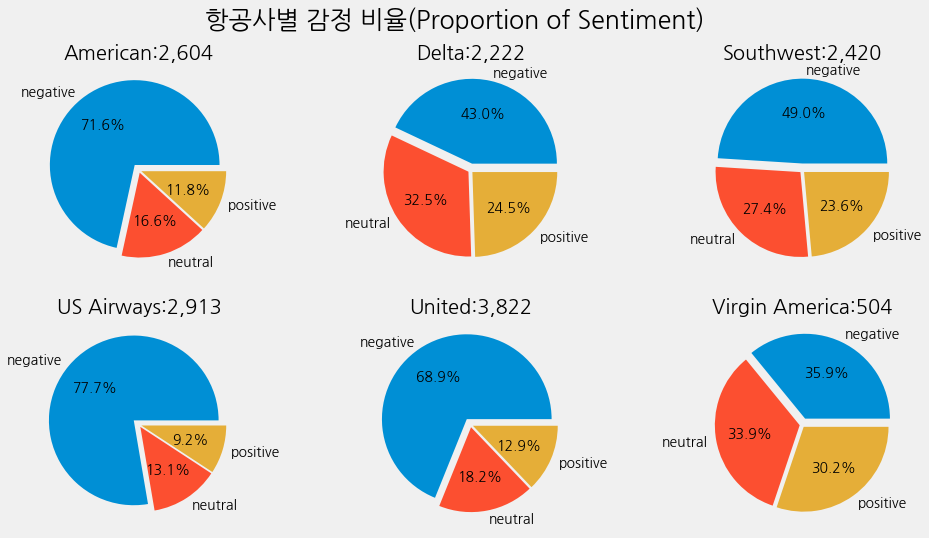

In [ ]:
fig, axes = plt.subplots(2, 3, figsize = (15, 8))
axes = axes.flatten()
for i, ax in zip(range(0, 6), axes):
    temp = a.iloc[i]    
    ax.pie(x = temp, labels = temp.index, autopct = '%1.1f%%', explode = [0.08, 0.03, 0.03])
    ax.set_title(f"{a.index[i]}:{format(a.values[i].sum(),',')}")

plt.suptitle("항공사별 감정 비율(Proportion of Sentiment)", fontsize = 25)    
plt.show()

#### 항공사에 부정적인 감정을 갖는 이유? (Reason for Negative sentiment)

In [ ]:
#위에서 분석한 결과 출력
print(df.negativereason.unique())

['' "Can't Tell" 'Late Flight' 'Customer Service Issue' 'Bad Flight'
 'Flight Booking Problems' 'Lost Luggage' 'Cancelled Flight'
 'Flight Attendant Complaints' 'longlines' 'Damaged Luggage']


In [ ]:
#감정 출력
print(df[df.negativereason == '']['sentiment'].unique())
print(df[df.negativereason != '']['sentiment'].unique())
# neutral  : 중립적 
# positive : 긍정적
# negative : 부정적

['neutral' 'positive']
['negative']


In [ ]:
#트위터 결과 출력
df_neg = df[df.sentiment == 'negative']
display(df_neg.shape, df_neg.head())

(9082, 4)

,airline,text,negativereason,sentiment
1,Delta,@JetBlue is REALLY getting on my nerves !! 😡😡 ...,Can't Tell,negative
2,United,@united yes. We waited in line for almost an h...,Late Flight,negative
3,United,@united the we got into the gate at IAH on tim...,Late Flight,negative
4,Southwest,@SouthwestAir its cool that my bags take a bit...,Customer Service Issue,negative
5,United,@united and don't hope for me having a nicer f...,Bad Flight,negative


항공사에 부정적인 감정을 갖는 사용자는 트위터에 부정적인 감정을 쓴다는 사실을 알수 있다.

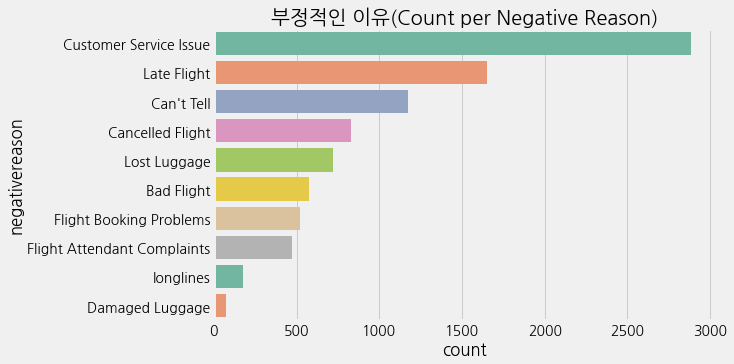

In [ ]:
plt.figure(figsize=(8,5))
ax = sns.countplot(data = df_neg, y = 'negativereason',
                   palette='Set2',
                   order = df_neg.negativereason.value_counts().index)

# ax.bar_label(ax.containers[1])
ax.set_title(('부정적인 이유(Count per Negative Reason)'))

plt.show()

전반적으로 고객 서비스 문제는 항공사에 대한 부정적인 감정을 가질 수 밖에 없는 요인 중 가장 크단 사실을 알 수 있다.

다음은 항공사 이름별로 정렬된 세부 정보이다.

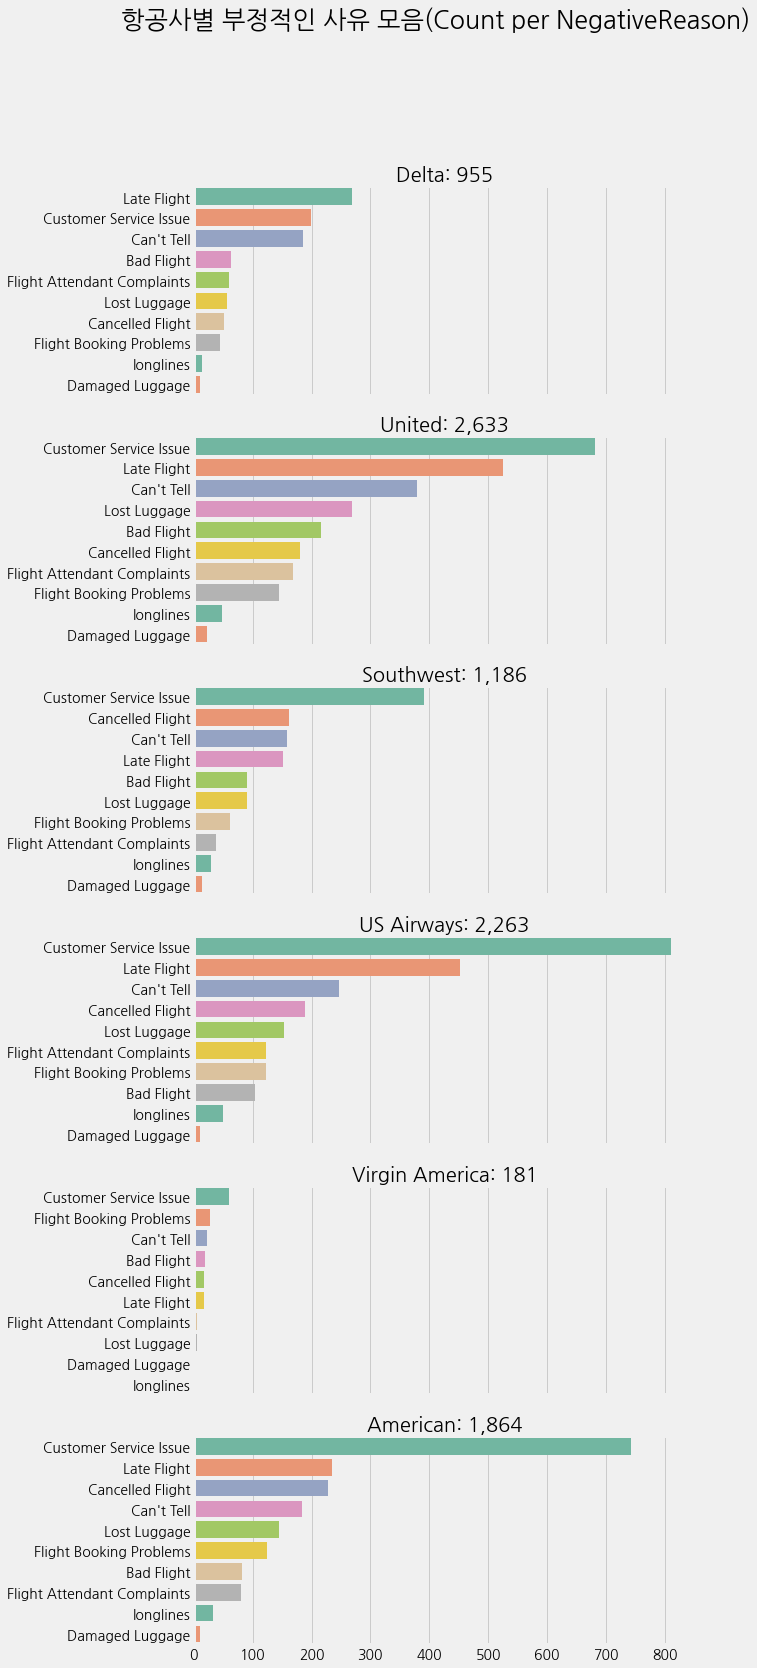

In [ ]:
fig, axes = plt.subplots(6, 1, figsize=(8, 25), sharex=True)
axes = axes.flatten()
names = df_neg['airline'].unique()

for name, n in zip(names, axes):
    ax = sns.countplot(data = df_neg[df_neg.airline==name], y = 'negativereason',
                       palette='Set2',
                       order = df_neg[df_neg.airline==name].negativereason.value_counts().index, ax = n)
    #ax.bar_label(ax.containers[0])
    ax.set_title(f"{name}: {format(len(df_neg[df_neg.airline==name]),',')}")
    ax.set_xlabel('')
    ax.set_ylabel('')

plt.suptitle("항공사별 부정적인 사유 모음(Count per NegativeReason)", fontsize = 25)
plt.show()

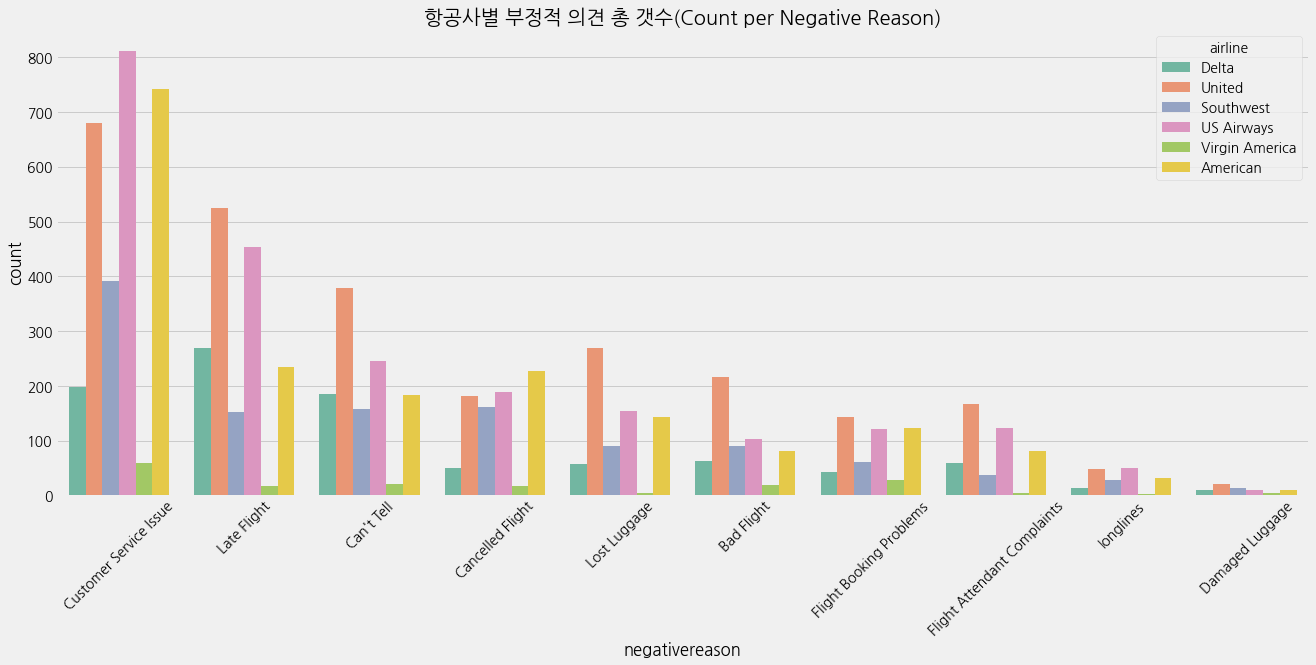

In [ ]:
plt.figure(figsize=(20,8))
ax = sns.countplot(data = df_neg, x = 'negativereason',
                   palette='Set2',
                   order = df_neg.negativereason.value_counts().index, hue = 'airline')

#ax.bar_label(ax.containers[0])
ax.set_title('항공사별 부정적 의견 총 갯수(Count per Negative Reason)')
plt.xticks(rotation=45)
plt.show()

In [ ]:
names = df.airline.unique()
for name in names:
    print(f"{name} : Out of total {format(len(df[df.airline == name]),',')}customers, {(len(df_neg[df_neg.airline == name]) / len(df[df.airline == name]))*100:.1f}% feel negative.\n")

Delta : Out of total 2,222customers, 43.0% feel negative.

United : Out of total 3,822customers, 68.9% feel negative.

Southwest : Out of total 2,420customers, 49.0% feel negative.

US Airways : Out of total 2,913customers, 77.7% feel negative.

Virgin America : Out of total 504customers, 35.9% feel negative.

American : Out of total 2,604customers, 71.6% feel negative.




### - 문자 전처리(Text Preprocessing)


※ 트위터에 작성가능한 텍스트의 수는 평균 103개의 길이를 가지며, 최소 길이는 12, 최대 길이는 386이다.

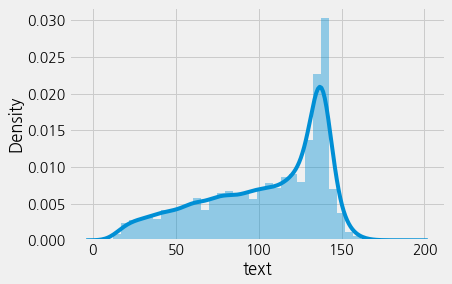

In [ ]:
sns.distplot(df.text.str.len())

plt.show()

In [ ]:
df.text.str.len().describe()

count    14485.000000
mean       103.836452
std         36.260307
min         12.000000
25%         77.000000
50%        114.000000
75%        136.000000
max        186.000000
Name: text, dtype: float64

#### 문자 전처리 절차
* 정규 표현

In [ ]:
# 샘플 텍스트 검토조건
# 모든 트윗은 @ + 항공사 이름으로 시작한다.
#http 형식, 이모티콘, 해시태그도 볼 수 있다.

#상위에서 추출한 트위터 글을 공백수에 따라 단어로 분류한다.
#트위터 글의 길이에 따라 0 ~ 10000까지 분류해서 처리
print(df.text[0].split(),'\n')
print(df.text[1].split(),'\n')
print(df.text[100].split(),'\n')
print(df.text[1000].split(),'\n')
print(df.text[10000].split())

["@JetBlue's", 'new', 'CEO', 'seeks', 'the', 'right', 'balance', 'to', 'please', 'passengers', 'and', 'Wall', '...', '-', 'Greenfield', 'Daily', 'Reporter', 'http://t.co/LM3opxkxch'] 

['@JetBlue', 'is', 'REALLY', 'getting', 'on', 'my', 'nerves', '!!', '😡😡', '#nothappy'] 

['@SouthwestAir', "I'm", 'an', 'A-list', 'Preferred', 'customer', 'and', 'very', 'loyal', 'SWA.', 'However,', 'your', 'inflight', 'wifi', 'is', 'no', 'better', 'today', 'than', 'it', 'was', '4', 'years', 'ago.'] 

['@SouthwestAir', 'I', 'got', 'it', 'added', 'thank', 'you!', ':)'] 

['@AmericanAir', 'lies,lies,lies.', 'Worst', 'travel', 'experience', 'of', 'my', 'life.', 'Day', '2', 'no', 'clothes', 'on', 'vaca.', '#lostluggage', '#unprofessional', '#pit', '#mia']


In [ ]:
!pip install nltk

* 토큰화

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
nltk.download('punkt')

# 불용어 작업
def clean_text(d):
    pattern = r'[^a-zA-Z\s]'
    text = re.sub(pattern, '', d)
    return text

names = ['delta', 'deltaair', 'united', 'unitedair', 'southwest', 'southwestair', 'usairways',
         'virginamerica', 'american', 'americanair', 'jetblue', 'jetblues', 'usairway',
         'flight', 'airline', 'airlines']

# 항공사 이름과 관련된 단어들은 감정 분석과 관련이 없으므로 
# 위의 이름들을 불용어 목록에 추가

def clean_stopword(d):
    stop_words = stopwords.words('english')
    for name in names:
        stop_words.append(name)
    return " ".join([w.lower() for w in d.split() if w.lower() not in stop_words and len(w) > 1])

def tokenize(d):
    return word_tokenize(d)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


* 불용어 체크

In [ ]:
df['final_text']= df.text.apply(clean_text).apply(clean_stopword).apply(tokenize)
df.final_text.head()

0    [new, ceo, seeks, right, balance, please, pass...
1                  [really, getting, nerves, nothappy]
2    [yes, waited, line, almost, hour, passengers, ...
3    [got, gate, iah, time, given, seats, closed, k...
4    [cool, bags, take, bit, longer, dont, give, ba...
Name: final_text, dtype: object

In [ ]:
print(" ".join(df.final_text[0]),'\n')
print(" ".join(df.final_text[1]),'\n')
print(" ".join(df.final_text[100]),'\n')
print(" ".join(df.final_text[1000]),'\n')
print(" ".join(df.final_text[10000]))

new ceo seeks right balance please passengers wall greenfield daily reporter httptcolmopxkxch 

really getting nerves nothappy 

im alist preferred customer loyal swa however inflight wifi better today years ago 

got added thank 

lieslieslies worst travel experience life day clothes vaca lostluggage unprofessional pit mia




## 문자 분석(Text Analysis)

In [ ]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
vader = SentimentIntensityAnalyzer()
vader.polarity_scores(" ".join(df.final_text[0]))

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


{'compound': 0.3182, 'neg': 0.0, 'neu': 0.827, 'pos': 0.173}

In [ ]:
texts = [" ".join(df.final_text[i]) for i in range(len(df))]

print(df.text[0])
print(texts[0])
print(vader.polarity_scores(texts[0]), f'--> Actual Classification: {df.sentiment[0]}', '\n')

print(df.text[1])
print(texts[1])
print(vader.polarity_scores(texts[1]), f'--> Actual Classification: {df.sentiment[1]}', '\n')

print(df.text[10])
print(texts[10])
print(vader.polarity_scores(texts[10]), f'--> Actual Classification: {df.sentiment[10]}', '\n')

print(df.text[100])
print(texts[100])
print(vader.polarity_scores(texts[100]), f'--> Actual Classification: {df.sentiment[100]}', '\n')

print(df.text[1000])
print(texts[1000])
print(vader.polarity_scores(texts[1000]), f'--> Actual Classification: {df.sentiment[1000]}', '\n')

print(df.text[10000])
print(texts[10000])
print(vader.polarity_scores(texts[10000]), f'--> Actual Classification: {df.sentiment[10000]}')

@JetBlue's new CEO seeks the right balance to please passengers and Wall ... - Greenfield Daily Reporter http://t.co/LM3opxkxch
new ceo seeks right balance please passengers wall greenfield daily reporter httptcolmopxkxch
{'neg': 0.0, 'neu': 0.827, 'pos': 0.173, 'compound': 0.3182} --> Actual Classification: neutral 

@JetBlue is REALLY getting on my nerves !! 😡😡 #nothappy
really getting nerves nothappy
{'neg': 0.359, 'neu': 0.641, 'pos': 0.0, 'compound': -0.1725} --> Actual Classification: negative 

Wanted to get my bag benefit, but instead get $25 pricing on all three tickets. When adding a card, MP Visa is only option. @united
wanted get bag benefit instead get pricing three tickets adding card mp visa option
{'neg': 0.0, 'neu': 0.812, 'pos': 0.188, 'compound': 0.4588} --> Actual Classification: negative 

@SouthwestAir I'm an A-list Preferred customer and very loyal SWA. However, your inflight wifi is no better today than it was 4 years ago.
im alist preferred customer loyal swa h

기존 ML 알고리즘에서는 결과가 개선되지 않았습니다.

<br>

* 단어구름 (WordCloud) : 키워드 알고리즘(Keyword analysis)

In [ ]:
# preprocessing before drawing wordcloud separating the sentiment.

positive = df[df.sentiment == 'positive'].text.apply(clean_text).apply(clean_stopword).apply(tokenize)
positive = [" ".join(positive.values[i]) for i in range(len(positive))]
positive = [" ".join(positive)][0]

negative = df[df.sentiment == 'negative'].text.apply(clean_text).apply(clean_stopword).apply(tokenize)
negative = [" ".join(negative.values[i]) for i in range(len(negative))]
negative = [" ".join(negative)][0]

neutral = df[df.sentiment == 'neutral'].text.apply(clean_text).apply(clean_stopword).apply(tokenize)
neutral = [" ".join(neutral.values[i]) for i in range(len(neutral))]
neutral = [" ".join(neutral)][0]

print(len(positive), len(negative), len(neutral))

114853 585364 149515


In [ ]:
from wordcloud import WordCloud

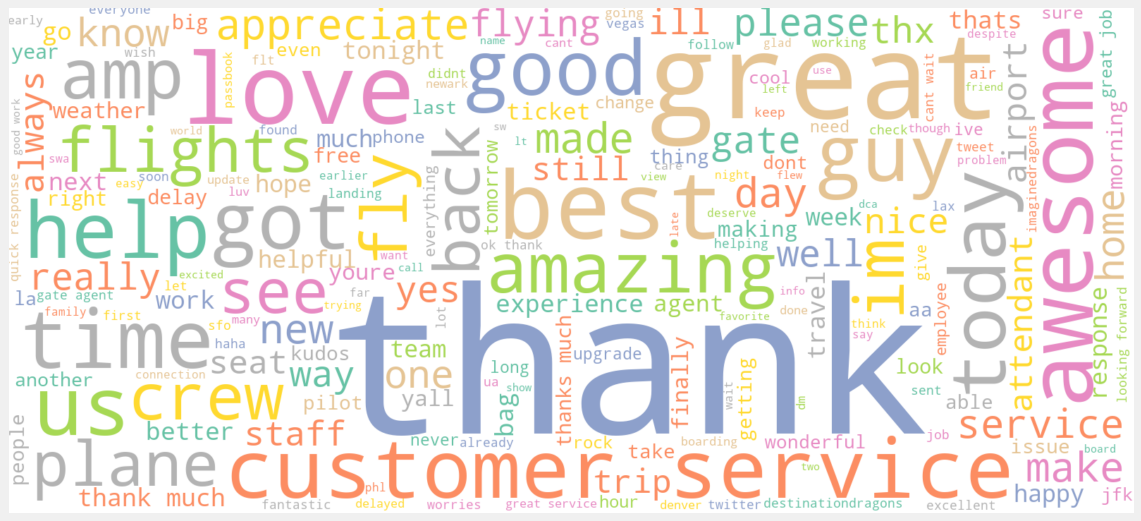

In [ ]:
plt.figure(figsize=(18,15))
wc_positive = WordCloud(min_font_size=3,max_words=200,width=1600,height=720,
                       colormap = 'Set2', background_color='white').generate(positive)

plt.imshow(wc_positive,interpolation='bilinear')
plt.xticks([])
plt.yticks([])
plt.grid(False)


긍정적인 단어가 눈에 띄인다. 'thank', 'great', 'love', etc.


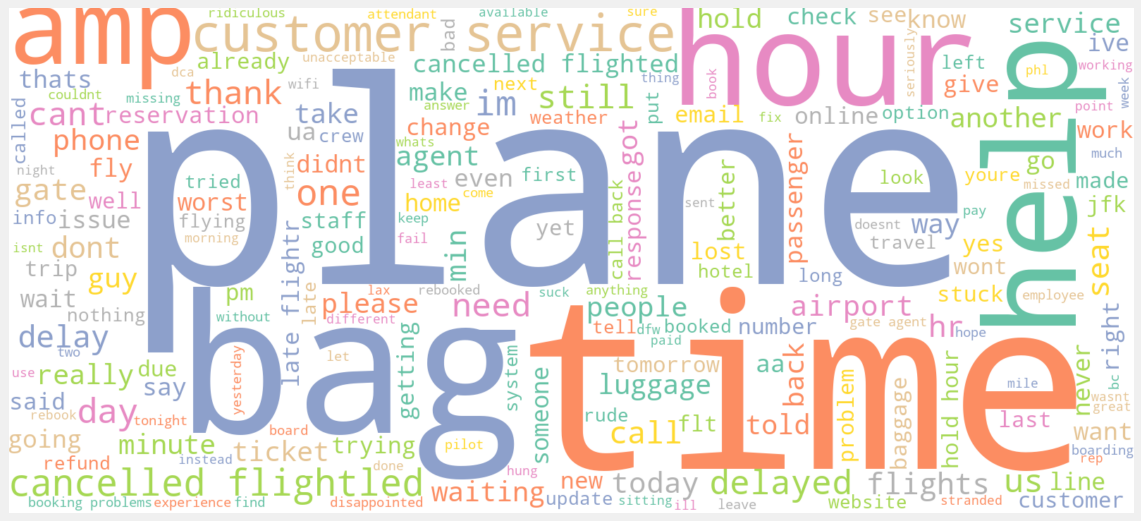

In [ ]:
plt.figure(figsize=(18,15))
wc_negative = WordCloud(min_font_size=3,max_words=200,width=1600,height=720,
                       colormap = 'Set2', background_color='white').generate(negative)

plt.imshow(wc_negative,interpolation='bilinear')
plt.xticks([])
plt.yticks([])
plt.grid(False)

<br>

부정적인 감정에서 주로 나타나는 단어는 'plane', 'bag', 'time', 'customer', 'service'이었고, 'plane'이란 단어가 가장 많이 나타남을 알 수 있다.

<br>

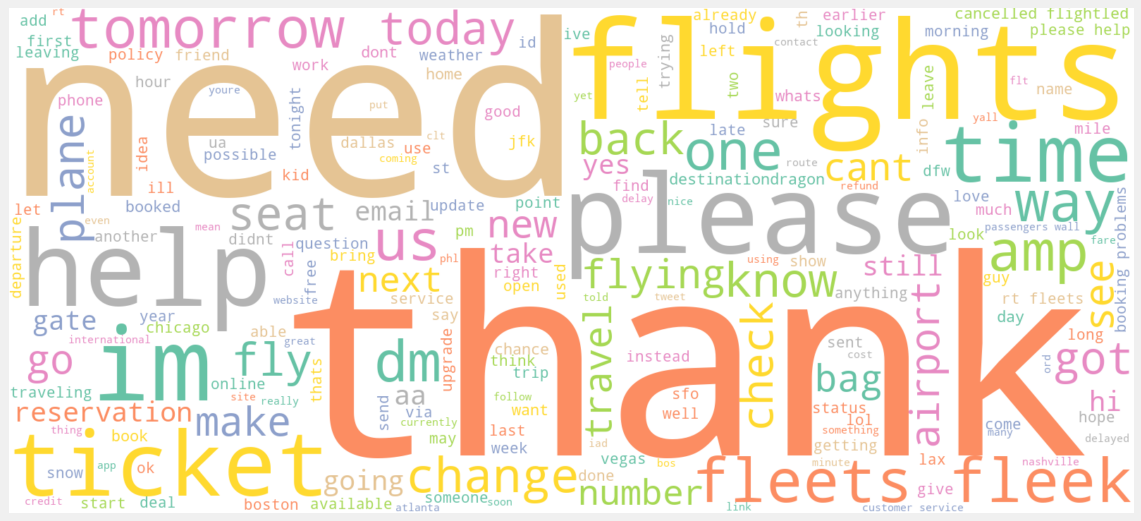

In [ ]:
plt.figure(figsize=(18,15))
wc_neutral = WordCloud(min_font_size=3,max_words=200,width=1600,height=720,
                       colormap = 'Set2', background_color='white').generate(neutral)

plt.imshow(wc_neutral,interpolation='bilinear')
plt.xticks([])
plt.yticks([])
plt.grid(False)

<br>

중립적인 의견이 많이 쓰는 단어는 'thank'였다.<br>
이걸로는 긍정인지 부정인지 알기가 어렵다,


<br>


### 머신러닝 접근법 (Machine Learning approach)
* Vectorization : `Word2Vec`

<br>

#### Word2Vec 

* 1,  skip-gram 을 설정하고 CBOW 값을 0으로 설정할 경우

In [ ]:
from gensim.models import Word2Vec

texts_w2v = df.final_text.apply(tokenize).to_list()

w2v = Word2Vec(sentences = texts_w2v, window = 3,
               vector_size = 100, min_count = 5, workers = 4, sg = 1)

In [ ]:
texts_w2v[:3]

[['new',
  'ceo',
  'seeks',
  'right',
  'balance',
  'please',
  'passengers',
  'wall',
  'greenfield',
  'daily',
  'reporter',
  'httptcolmopxkxch'],
 ['really', 'getting', 'nerves', 'nothappy'],
 ['yes',
  'waited',
  'line',
  'almost',
  'hour',
  'passengers',
  'left',
  'wanting',
  'wait',
  'past']]

<br>

gensim에서 가져운 Word2Vec은 사용자가 선언한 것과 동시에 텍스트를 훈련시킨다.

주어진 단어와 비슷한 단어들을 찾을 수 있는데, 그 예는 다음과 같다.

<br>

In [ ]:
w2v.wv.most_similar('thank')

[('thanks', 0.9641565084457397),
 ('much', 0.9630759954452515),
 ('appreciate', 0.9599449634552002),
 ('quick', 0.9562839865684509),
 ('amazing', 0.949322521686554),
 ('awesome', 0.9439476132392883),
 ('twitter', 0.9348067045211792),
 ('response', 0.9325140118598938),
 ('care', 0.9279189705848694),
 ('team', 0.9186081290245056)]

In [ ]:
w2v.wv.most_similar('customerservice')

[('neveragain', 0.9942463040351868),
 ('est', 0.9920832514762878),
 ('unhelpful', 0.9918454885482788),
 ('cs', 0.9918360114097595),
 ('abysmal', 0.9916560649871826),
 ('excuse', 0.9916508197784424),
 ('literally', 0.9914224147796631),
 ('zero', 0.9912195205688477),
 ('frustrating', 0.9910000562667847),
 ('officially', 0.9908047914505005)]

In [ ]:
w2v.wv.most_similar('crew')

[('ground', 0.9350550174713135),
 ('ua', 0.9175152778625488),
 ('landing', 0.9131448268890381),
 ('staff', 0.9101159572601318),
 ('attendant', 0.9045068025588989),
 ('pilot', 0.9015213251113892),
 ('sfo', 0.8988414406776428),
 ('san', 0.8984569907188416),
 ('open', 0.8926225900650024),
 ('phx', 0.8877385258674622)]

In [ ]:
w2v.wv.most_similar('delay')

[('delayed', 0.9052019119262695),
 ('runway', 0.8900796175003052),
 ('tarmac', 0.8844099640846252),
 ('ua', 0.8750215768814087),
 ('ground', 0.8745144009590149),
 ('sitting', 0.8741441965103149),
 ('issues', 0.8740484714508057),
 ('half', 0.8738468289375305),
 ('stuck', 0.8705759048461914),
 ('ord', 0.8702757954597473)]

In [ ]:
w2v.wv.most_similar('bag')

[('bags', 0.9107496738433838),
 ('luggage', 0.9096060991287231),
 ('checked', 0.9009636640548706),
 ('baggage', 0.8942973613739014),
 ('carry', 0.8658499717712402),
 ('found', 0.8536415696144104),
 ('extra', 0.8441439270973206),
 ('claim', 0.8371927738189697),
 ('board', 0.8357154130935669),
 ('broken', 0.8296507000923157)]

In [ ]:
w2v.wv.most_similar('ticket')

[('refund', 0.9463787078857422),
 ('fee', 0.9399096369743347),
 ('name', 0.9266740083694458),
 ('add', 0.9172744750976562),
 ('booked', 0.916528046131134),
 ('use', 0.9144318699836731),
 ('credit', 0.9125540256500244),
 ('online', 0.9114885330200195),
 ('reservation', 0.9092071652412415),
 ('award', 0.9091234803199768)]

In [ ]:
w2v.wv.most_similar('booking')

[('reflight', 0.9084571003913879),
 ('problems', 0.7982682585716248),
 ('fee', 0.7576348185539246),
 ('using', 0.7379850149154663),
 ('website', 0.716666579246521),
 ('online', 0.7120557427406311),
 ('error', 0.7080553770065308),
 ('process', 0.7044789791107178),
 ('options', 0.7033239006996155),
 ('ticket', 0.6971046924591064)]

In [ ]:
def get_avg_vector(sent):
    vector = np.zeros(100)
    total_words = 0
    for word in sent.split():        
        if word in w2v.wv.index_to_key:    # don't use .wv.vocab method in kaggle notebook. instead, use .wv.index_to_key method.
            vector += w2v.wv.word_vec(word)
            total_words += 1
    if total_words > 0:
        return vector / total_words
    else:
        return vector
    
df['w2v_vector'] = df['final_text'].map(get_avg_vector)
df[['final_text', 'w2v_vector']].head(2)

,final_text,w2v_vector
0,new ceo seeks right balance please passengers ...,"[-0.03660955631898509, 0.07767275852772097, -0..."
1,really getting nerves nothappy,"[-0.046073486097157, 0.0834657537440459, 0.014..."


In [ ]:
model_params = {'random_state':42}
model_list = [LogisticRegression(**model_params, solver='liblinear'),
              RandomForestClassifier(**model_params),
#               MultinomialNB(),  # Don't use Naive Bayes since w2v_vector contains negative numbers, then it causes an error.
              SVC(**model_params)]
model_name = ['LogisticRegression', 'RandomForest', 'SupportVectorMachine']

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for model, model_name in zip(model_list, model_name):
    for n_fold, (trn_idx, vld_idx) in enumerate(skf.split(df.index, df.sentiment)):        
        X_trn = np.stack(df.loc[trn_idx, 'w2v_vector'])
        y_trn = df.loc[trn_idx, 'sentiment']
        
        X_vld = np.stack(df.loc[vld_idx, 'w2v_vector'])
        y_vld = df.loc[vld_idx, 'sentiment']        
        
        model.fit(X_trn, y_trn)
        pred_col = f"{model_name}_w2v_pred"
        df.loc[vld_idx, pred_col] = model.predict(X_vld)
        

    print(f"Model: {model_name}, Word2Vec, Accuracy: {accuracy_score(df.sentiment, df[pred_col]):.3%}\n")

Model: LogisticRegression, Word2Vec, Accuracy: 71.129%

Model: RandomForest, Word2Vec, Accuracy: 72.330%

Model: SupportVectorMachine, Word2Vec, Accuracy: 70.031%



In [ ]:
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [ ]:
df.final_text

0        [new, ceo, seeks, right, balance, please, pass...
1                      [really, getting, nerves, nothappy]
2        [yes, waited, line, almost, hour, passengers, ...
3        [got, gate, iah, time, given, seats, closed, k...
4        [cool, bags, take, bit, longer, dont, give, ba...
                               ...                        
14480              [hope, fly, often, would, hate, change]
14481                     [dm, possible, arent, following]
14482    [yesterday, way, ewr, fll, takeoff, wheelsup, ...
14483                      [one, agents, available, speak]
14484    [better, time, call, friday, need, change, wor...
Name: final_text, Length: 14485, dtype: object

In [ ]:
for i in range(len(df)):
    df['final_text'][i] = " ".join(df['final_text'][i])

In [ ]:
df['final_text'][:3]

0    new ceo seeks right balance please passengers ...
1                       really getting nerves nothappy
2    yes waited line almost hour passengers left wa...
Name: final_text, dtype: object

In [ ]:
def convert_Sentiment(sentiment):
    if  sentiment == "positive":
        return 2
    elif sentiment == "neutral":
        return 1
    elif sentiment == "negative":
        return 0
    
df.sentiment = df.sentiment.apply(lambda x : convert_Sentiment(x))

In [ ]:
X = df.final_text
y = df.sentiment

<br>

#### LSTM 

In [3]:
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Bidirectional,Embedding, Dropout, Conv1D, MaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.vis_utils import plot_model
from keras.callbacks import EarlyStopping

In [17]:
max_words = 5000
max_len = 100

def tokenize_pad_sequences(text):
 '''
이 함수는 입력 텍스트를 인터럽터의 중요도로 토큰화한 다음
각 시퀀스를 같은 길이로 패딩하다
'''
    # Text tokenization
    tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
    tokenizer.fit_on_texts(text)
    # Transforms text to a sequence of integers
    X = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    X = pad_sequences(X, padding='post', maxlen=max_len)
    # return sequences
    return X, tokenizer

print('토큰화 및 패딩 전 \n', df['final_text'][0],'\n')
X, tokenizer = tokenize_pad_sequences(df['final_text'])
print('토큰화 및 패딩 후 \n', X[0])

IndentationError: ignored

In [4]:
y = pd.get_dummies(df.sentiment)
X_trn, X_tst, y_trn, y_tst = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_trn, X_vld, y_trn, y_vld = train_test_split(X_trn, y_trn, test_size=0.3, random_state=42, stratify=y_trn)

print('Train:         ', X_trn.shape, y_trn.shape)
print('Validation Set:', X_vld.shape, y_vld.shape)
print('Test Set:      ', X_tst.shape, y_tst.shape)

NameError: ignored

In [3]:
vocab_size = 5000
embedding_size = 32
epochs=50

model= Sequential()
model.add(Embedding(vocab_size, embedding_size, input_length=max_len))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.4))
model.add(Dense(3, activation='softmax'))

plot_model(model, show_shapes = True)

NameError: ignored

In [2]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

NameError: ignored

In [ ]:
es = EarlyStopping(monitor = 'val_loss', patience=5)
batch_size = 64

history = model.fit(X_trn, y_trn,
                    validation_data=(X_vld, y_vld),
                    batch_size=batch_size, epochs=epochs, verbose=1,
                    callbacks = [es])

In [ ]:
# Evaluate model on the test set
loss, accuracy = model.evaluate(X_tst, y_tst, verbose=0)

# Print metrics
print('Accuracy  : {:.4f}'.format(accuracy))

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b--', label = 'loss')
plt.plot(history.history['val_loss'], 'r:', label = 'val_loss')
plt.xlabel('Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'b--', label = 'acc')
plt.plot(history.history['val_accuracy'], 'r:', label = 'val_acc')
plt.xlabel('Epochs')
plt.legend()

plt.show()

In [1]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, X_test, y_test):
    '''Function to plot confusion matrix for the passed model and the data'''
    
    sentiment_classes = ['Negative', 'Neutral', 'Positive']
    # use model to do the prediction
    y_pred = model.predict(X_test)
    # compute confusion matrix
    cm = confusion_matrix(np.argmax(np.array(y_test),axis=1), np.argmax(y_pred, axis=1))
    # plot confusion matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d', 
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes)
    plt.title('Confusion matrix', fontsize=16)
    plt.xlabel('Actual label', fontsize=12)
    plt.ylabel('Predicted label', fontsize=12)
    
plot_confusion_matrix(model, X_tst, y_tst)

NameError: ignored

### Thanks you, Code states AIB 9TH Crews!